## Run auto segmentation using a trained neural network
Requires monai v0.8.0

In [63]:
import os
import time
import sys
import tempfile
import glob
import matplotlib.pyplot as plt

import nibabel as nib
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import create_test_image_3d, list_data_collate, decollate_batch
from monai.inferers import sliding_window_inference
from monai.metrics import (
    DiceMetric,
    HausdorffDistanceMetric,
    ConfusionMatrixMetric,
    RMSEMetric,
    ROCAUCMetric,
    compute_confusion_matrix_metric,
    do_metric_reduction,
    compute_hausdorff_distance
)
from monai.transforms import (
    Activations,
    AddChannelD,
    AsChannelFirstd,
    AsDiscrete,
    CenterSpatialCropd,
    Compose,
    CropForegroundd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandCropByPosNegLabeld,
    RandSpatialCropd,
    Spacingd,
    ToTensord,
    ToTensor,
    KeepLargestConnectedComponent,
    LabelToContour
)
from monai.visualize import plot_2d_or_3d_image

from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.utils import set_determinism, first

from sklearn.metrics import confusion_matrix

print('Imports Complete')

Imports Complete


Load in the trained weights 

In [3]:
model_path = "C:\\Users\\Johnny\\Documents\\Maria's Stuff\\ABI\\Knee Segmentation\\trained_weights\\13Dec_v3_intactKnees_12816_b4.pth"

print("The model is in:", model_path)

The model is in: C:\Users\Johnny\Documents\Maria's Stuff\ABI\Knee Segmentation\trained_weights\13Dec_v3_intactKnees_12816_b4.pth


Set up the neural network model (UNET) and parameters on the CUDA GPU


In [64]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=3,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)
loss_function = DiceLoss(to_onehot_y=False, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(
    model.parameters(), 1e-4, weight_decay=1e-5, amsgrad=True
)


In [80]:
# Set up Metrics
dice_metric = DiceMetric(include_background=True, reduction="mean")
hausdorff_metric = HausdorffDistanceMetric(include_background=True, distance_metric="euclidean", directed=True)
confusion_matrix_metric = ConfusionMatrixMetric(include_background=True, metric_name=["sensitivity", "specificity", "precision", "negative predictive value", "miss rate", "fall out", "false discovery rate", "false omission rate", "accuracy", "balanced accuracy", "f1 score", "matthews correlation coefficient", "fowlkes mallows index", "informedness", "markedness"],
                                                compute_sample=False)
auc_metric = ROCAUCMetric()
rmse_metric = RMSEMetric()


In [6]:
# image_path =  'G:\\My Drive\\MINI_ANON_UNISPORTS\\ImagesNIFTI2'
# mask_path = 'G:\\My Drive\\MINI_ANON_UNISPORTS\\Masks' 

image_path =  'G:\\My Drive\\Pickles\\niftiMRI'
mask_path = 'G:\\My Drive\\Pickles\\niftiMasks' 

# Sort the files and add the nifti suffix to complete the pathnames
images = sorted(
    glob.glob(os.path.join(image_path, ("*.nii.gz"))) 
    ) 
labels = sorted(
    glob.glob(os.path.join(mask_path, "*.nii.gz")))

data = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(images, labels)
]


print("TOTAL files: ", len(data))


TOTAL files:  199


In [7]:
class ConvertToMultiChannelBasedOnClassesd(MapTransform):
    """
    Convert labels to multi channels:
    label 1 is the femur
    label 2 is the tibia
    label 3 is the ACL
    The possible classes are F (Femur), T (Tibia)
    and ACL (Anterior Cruciate Ligament).

    """

    def __call__(self, data):
        d = dict(data)
        result = []
        for key in self.keys:
            # Femur is first channel
            result.append(d[key] == 1)
            # Tibia is second channel
            result.append(d[key] == 2)
            # ACL is third
            result.append(d[key] == 3)

            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d


class MyRotate:
    """
    Rotates the images and label of our MRNet/CHCR dataset and masks
    so that they align to each other.
    """
    def __call__(self,d):    
        d["image"] = np.swapaxes(d["image"], 0, 2)
        d["image"] = np.swapaxes(d["image"], 1, 0)

        # d["image"] = np.rot90(d["image"], k=2)
        d["label"] = np.swapaxes(d["label"], 1, 0)
        #print("Rotated to-->", d["image"].shape)
        #print("Matching label is ", d["label"].shape)

        return d

In [8]:
basic_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        MyRotate(),
        AddChannelD(keys=["image"]),  
        ConvertToMultiChannelBasedOnClassesd(keys="label"),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[480, 480, 38]), #246
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        ToTensord(keys=["image", "label"]),
    ]
)

dataset = monai.data.Dataset(data=data, transform=basic_transform)
dataloader = DataLoader(dataset, batch_size=1, num_workers=0, collate_fn=list_data_collate)

In [9]:
check_data = first(dataloader)
print(check_data["image"].shape, check_data["label"].shape)

torch.Size([1, 1, 256, 256, 38]) torch.Size([1, 3, 256, 256, 38])


image shape: torch.Size([1, 256, 256, 26])


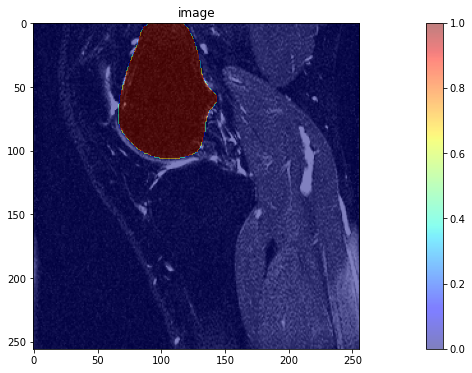

In [10]:

# pick one image from data to visualize and check 
img = dataset[3]

print(f"image shape: {img['image'].shape}")
plt.figure("image", (24, 6))
plt.title(f"image")
# plt.imshow(img["image"][0, :, :,15].detach().cpu(), cmap="gray")
plt.imshow(img["image"][0, :, :,15], cmap="gray")
plt.imshow(img["label"][0, :, :, 15], cmap="jet", alpha=0.5)
plt.colorbar()
plt.show()

torch.Size([1, 256, 256, 38])
Dice Score: 0.7097504138946533


the prediction of class 128 is all 0, this may result in nan/inf distance.
the prediction of class 129 is all 0, this may result in nan/inf distance.
the ground truth of class 130 is all 0, this may result in nan/inf distance.
the prediction of class 130 is all 0, this may result in nan/inf distance.
the ground truth of class 131 is all 0, this may result in nan/inf distance.
the prediction of class 131 is all 0, this may result in nan/inf distance.
the ground truth of class 132 is all 0, this may result in nan/inf distance.
the prediction of class 132 is all 0, this may result in nan/inf distance.
the ground truth of class 133 is all 0, this may result in nan/inf distance.
the prediction of class 133 is all 0, this may result in nan/inf distance.
the ground truth of class 134 is all 0, this may result in nan/inf distance.
the prediction of class 134 is all 0, this may result in nan/inf distance.
the ground truth of class 135 is all 0, this may result in nan/inf distance.
the predictio

Hausdorff Distance: inf
RMSE: 0.08644881844520569
sensitivity: 0.9081180691719055
specificity: 0.9953611493110657
precision: 0.9177229404449463
negative predictive value: 0.9947677850723267
miss rate: 0.0918819010257721
fall out: 0.004638927057385445
false discovery rate: 0.08227705955505371
false omission rate: 0.005232136230915785
accuracy: 0.9906581044197083
balanced accuracy: 0.9517396092414856
f1 score: 0.9128952622413635
matthews correlation coefficient: 0.9079738259315491
fowlkes mallows index: 0.9129078984260559
informedness: 0.9034792184829712
markedness: 0.912490725517273


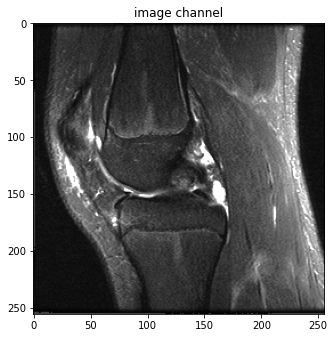

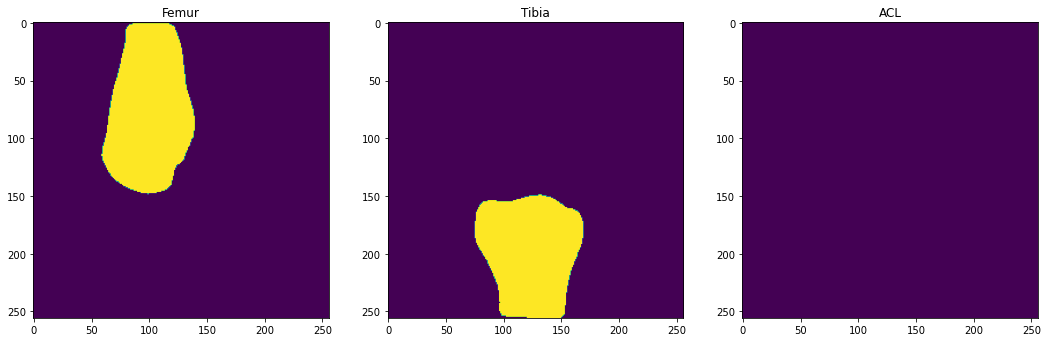

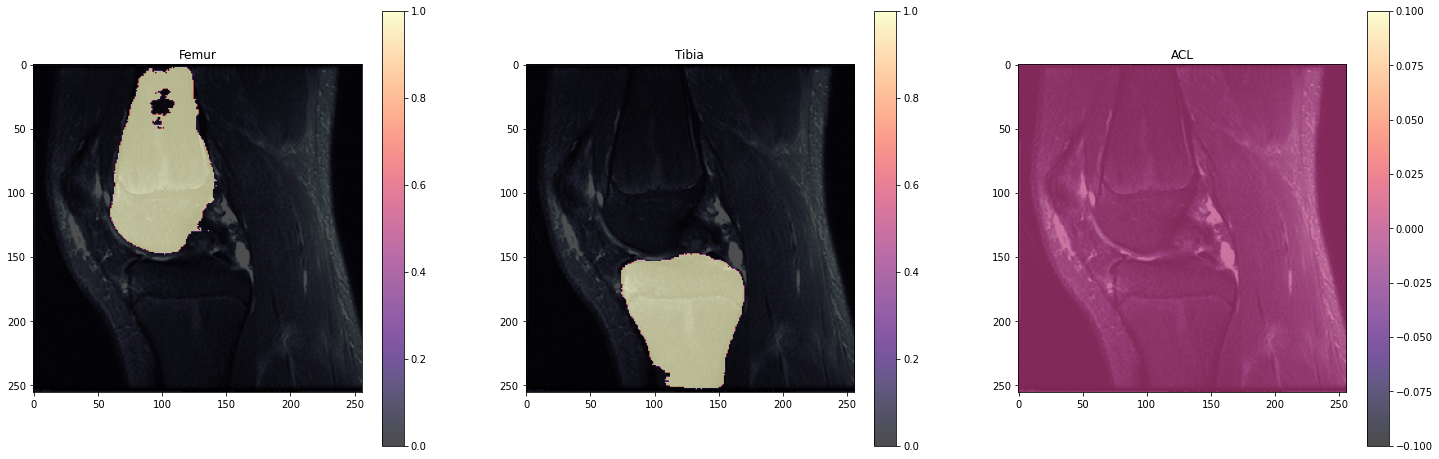

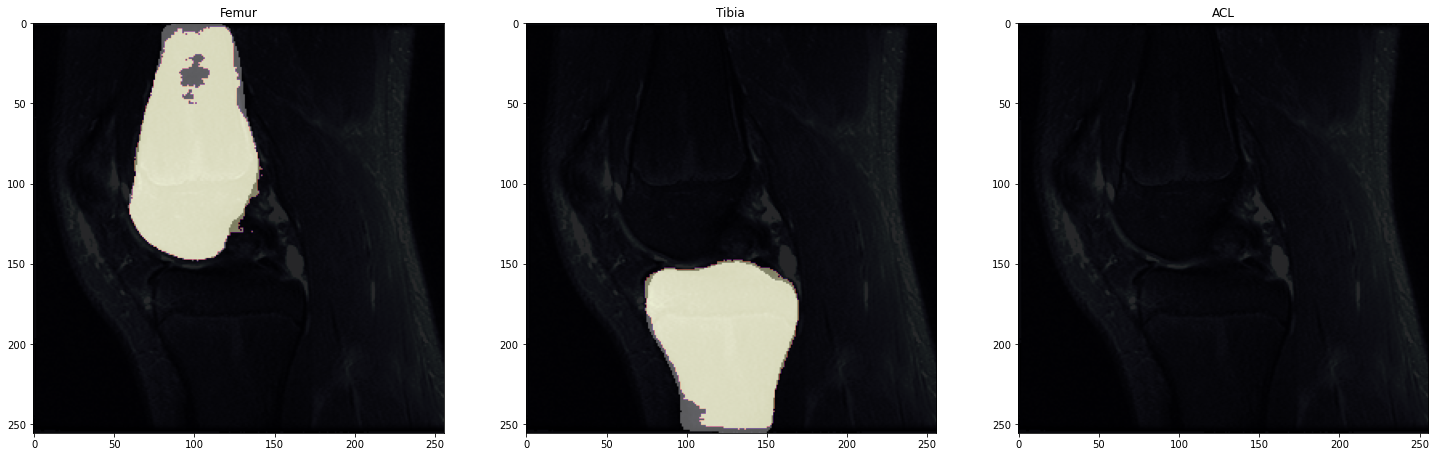

In [83]:
# Load the trained model (default to GPU. state to CPU if needed)
model.load_state_dict(
    torch.load("C:\\Users\\Johnny\\Documents\\Maria's Stuff\\ABI\\Knee Segmentation\\trained_weights\\13Dec_v2_intactKnees_12816_b4.pth")
)

def get_name(number):
    if (number == 0):
        return 'Femur'
    elif (number == 1):
        return 'Tibia'
    elif (number == 2):
        return 'ACL'
    else:
        return 'Unknown'


#~ Evaluate the model 
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    subject =  dataset[8]  # Select one scan from the final test dataset     
    SLICE = 16              # Adjust Slice number here
    roi_size = (256,256,16)
    sw_batch_size = 4

    val_input = subject["image"].unsqueeze(0).to(device)
    print(subject["image"].shape)
    # val_output = model(val_input)
    val_output = sliding_window_inference(
            val_input, roi_size, sw_batch_size, model
        )
    
    after_transform = Compose([
                     Activations(sigmoid=True), AsDiscrete(threshold_values=0.5),
                 KeepLargestConnectedComponent(applied_labels=[0,1,2], independent=True)
    ])
    val_output = after_transform(val_output)

    # Plot the results
    plt.figure("image", (24, 6))
    plt.subplot(1, 4,1)
    plt.title(f"image channel")
    plt.imshow(subject["image"][0, :, :, SLICE].detach().cpu(), cmap="gray")

    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        anatomy = get_name(i)
        plt.title(f"{anatomy}")
        plt.imshow(subject["label"][i, :, :, SLICE].detach().cpu())


    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (25, 8))
    for i in range(3):
        anatomy = get_name(i)
        plt.subplot(1, 3, i + 1)
        plt.title(f"{anatomy}")
        plt.imshow(subject["image"][0, :, :, SLICE].detach().cpu(), cmap="bone")
        plt.imshow(val_output[0, i, :, :, SLICE].detach().cpu(), alpha=0.7, cmap="magma")
        plt.colorbar()


    plt.figure("overlay", (25, 8))
    for i in range(3):
        anatomy = get_name(i)
        plt.subplot(1, 3, i + 1)
        plt.title(f"{anatomy}")
        plt.imshow(subject["image"][0, :, :, SLICE].detach().cpu(), cmap="bone")
        plt.imshow(subject["label"][i, :, :, SLICE].detach().cpu(), alpha=0.7, cmap="gist_gray")
        plt.imshow(val_output[0, i, :, :, SLICE].detach().cpu(), alpha=0.5, cmap="magma")
        # plt.colorbar()

        
    # plt.show()

    dice_metric(y_pred=subject["label"].detach().cuda(), y=val_output.squeeze())
    dice_value = dice_metric.aggregate().item()
    print("Dice Score:", dice_value)

    hausdorff_metric(y_pred=subject["label"].detach().cuda(), y=val_output.squeeze())
    hd_value = hausdorff_metric.aggregate().item()
    print("Hausdorff Distance:", hd_value)

    rmse_metric(y_pred=subject["label"].detach().cuda(), y=val_output.squeeze())
    rmse_value = rmse_metric.aggregate().item()
    print("RMSE:", rmse_value)

    confusion_matrix_metric(y_pred=subject["label"].detach().cuda(), y=val_output.squeeze())
    confusion = confusion_matrix_metric.aggregate()
    metric_name=["sensitivity", "specificity", "precision", "negative predictive value", "miss rate", "fall out", "false discovery rate", "false omission rate", "accuracy", "balanced accuracy", "f1 score", "matthews correlation coefficient", "fowlkes mallows index", "informedness", "markedness"]
    j = 0
    for i in metric_name:
        print(f'{i}: {confusion[j].item()}')
        j+=1



In [74]:
model.load_state_dict(
    torch.load("C:\\Users\\Johnny\\Documents\\Maria's Stuff\\ABI\\Knee Segmentation\\trained_weights\\13Dec_v2_intactKnees_12816_b4.pth")
)
model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

y_true = list()
y_pred = list()
with torch.no_grad():
    for test_data in dataloader:
        test_images, test_labels = (
            test_data["image"].unsqueeze(0).to(device),
            test_data["label"].to(device),
        )
        print(test_images)
        pred = model(test_images).argmax(dim=1)
        
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

tensor([[[[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
            ...,
            [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

           [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
            [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
            ...,
            [-0.9908, -1.0105, -0.9908,  ...,  0.0000,  0.0000,  0.0000],
            [-0.9908, -0.9908, -1.0105,  ...,  0.0000,  0.0000,  0.0000],
            [-1.0105, -0.9908, -1.0303,  ...,  0.0000,  0.0000,  0.0000]],

           [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],


RuntimeError: Expected 5-dimensional input for 5-dimensional weight [32, 1, 3, 3, 3], but got 6-dimensional input of size [1, 1, 1, 256, 256, 38] instead

Get details of the curent NVIDIA GPU in use

In [ ]:
!nvidia-smi